In [1]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from BasicDataset import BasicDataset
# from BasicTransformer import BasicTransformer

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
# Basic Dataset only loads the HRIRs at 0 degrees and 90 degrees for baseline and 45 degree for testing
hrir_dataset = BasicDataset()
for i in range(1,100):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

In [2]:
hrir_dataset[0]

len(hrir_dataset)

99

In [3]:
import math
import torch
import torch.nn as nn
from PositionalEncoding import PositionalEncoding
import torch.nn.functional as F
# load first iteam from the dataset
# hrirs0, angle0, hrirs90, angle90, hrirs45, angle45 = hrir_dataset[0]

# hrirs0, angle0, hrirs90, angle90, hrirs45, angle45
train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])
from torch.utils.data import DataLoader
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)


In [4]:
import math
import torch
import torch.nn as nn
from PositionalEncoding import PositionalEncoding
import torch.nn.functional as F
class BasicTransformer(nn.Module):
    # d_model=192, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, angle_dim=64
    def __init__(self, d_model=512, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=1024, dropout=0.0, max_len=512):
        super(BasicTransformer, self).__init__()
        
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_encoder_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.angle_encoder = nn.Linear(1, d_model)  # Encodes angle to a high-dimensional space
        self.encoder = nn.Linear(d_model, d_model)  # Adjusted for concatenated angles
        self.decoder = nn.Linear(d_model, d_model)  # Output HRIR prediction
        self.d_model = d_model
        self.angle_dim = d_model
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.weight.data.uniform_(-initrange, initrange)
        self.angle_encoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, hrir0, angle0, hrir90, angle90, hrir45, angle45):
        # batch, seq_len, d_model = 32, n, 512
        # Encode the angles
        angle0 = self.angle_encoder(angle0.unsqueeze(-1))
        angle90 = self.angle_encoder(angle90.unsqueeze(-1))
        angle45 = self.angle_encoder(angle45.unsqueeze(-1))
        
        # batch, 512
        # convert to batch, 1, 512
        angle0 = angle0.unsqueeze(1)
        angle90 = angle90.unsqueeze(1)
        angle45 = angle45.unsqueeze(1)

        # Concatenate the encoded angles with the HRIR data
        # angles = [32, 1, 512]
        # hrir0 = [32, 2, 512]
        # concated = [32, 3, 512]
        concated0 = torch.cat([hrir0, angle0], dim=1)
        concated90 = torch.cat([hrir90, angle90], dim=1)
        # print(concated0.shape, concated90.shape, angle45.shape)
        # concated45 = torch.cat([hrir45, angle45], dim=1)

        # Concate the 3 angles
        # concated = [32, 7, 512]
        concated = torch.cat([concated0, concated90, angle45], dim=1)
        # print(concated.shape)

        # Encode the concatenated data
        src = self.encoder(concated) * math.sqrt(self.d_model)

        # Add positional encoding
        src = self.pos_encoder(src)

        # Encode the data
        memory = self.transformer_encoder(src)

        # Decode the data
        # Encode the target data
        tgt_encoded = self.encoder(hrir45) * math.sqrt(self.d_model)  # Apply encoding and scale
        tgt_pos_encoded = self.pos_encoder(tgt_encoded)  # Apply positional encoding
        # print(tgt_pos_encoded.shape, memory.shape)

        # Decode the data
        output = self.transformer_decoder(tgt_pos_encoded, memory)
        output = self.decoder(output)
        return output



# Test the forward method



In [10]:
# # Load one batch of data
# hrir0, angle0, hrir90, angle90, hrir45, angle45 = next(iter(train_loader))

# # print(hrir0.shape)
# # print(angle0.shape)
# # print(hrir90.shape)
# # print(angle90.shape)
# # print(hrir45.shape)
# # print(angle45.shape)
# output = model(hrir0, angle0, hrir90, angle90, hrir45, angle45)
# print(output.shape)


In [5]:


def train_epoch(model, data_loader, loss_function, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for hrir0, angle0, hrir90, angle90, hrir45, angle45 in data_loader:
        # move all to device
        hrir0, angle0, hrir90, angle90, hrir45, angle45 = hrir0.to(device), angle0.to(device), hrir90.to(device), angle90.to(device), hrir45.to(device), angle45.to(device)

        # normalize between -1 and 1
        hrir0 = (hrir0 - hrir0.mean()) / hrir0.std()
        hrir90 = (hrir90 - hrir90.mean()) / hrir90.std()
        hrir45 = (hrir45 - hrir45.mean()) / hrir45.std()

        output = model(hrir0, angle0, hrir90, angle90, hrir45, angle45)


        loss = loss_function(output, hrir45)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Update the learning rate
    scheduler.step()
    
    return total_loss / len(data_loader)

def validate_epoch(model, data_loader, loss_function, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for hrir0, angle0, hrir90, angle90, hrir45, angle45 in data_loader:
            # move all to device
            hrir0, angle0, hrir90, angle90, hrir45, angle45 = hrir0.to(device), angle0.to(device), hrir90.to(device), angle90.to(device), hrir45.to(device), angle45.to(device)
        
            output = model(hrir0, angle0, hrir90, angle90, hrir45, angle45)
            
            # Compute loss
            loss = loss_function(output, hrir45)
            
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [12]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from BasicDataset import BasicDataset
# from BasicTransformer import BasicTransformer

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
# Basic Dataset only loads the HRIRs at 0 degrees and 90 degrees for baseline and 45 degree for testing
hrir_dataset = BasicDataset()
for i in range(1,100):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

import numpy as np
from torch.utils.data import DataLoader

import torch.optim as optim
import torch
import torch.nn as nn

device = torch.device('cuda')

loss_function = nn.MSELoss()

num_epochs = 200 # Number of epochs to train for

# total_epochs = 100
warmup_epochs = 10
base_lr = 1e-3

# Define lambda function for the learning rate schedule
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        # Linear warm-up
        return float(epoch) / float(max(1, warmup_epochs))
    else:
        # Exponential decay
        decay_rate = 0.95  # Decay rate
        decay_epochs = epoch - warmup_epochs  # Subtract warmup epochs
        return pow(decay_rate, decay_epochs)

nhead = 8
encoder_layer = 6
decoder_layer = 6
feedforward_dim = 2048


train_size = int(0.7 * len(hrir_dataset))
val_size = int(0.2 * len(hrir_dataset))
test_size = len(hrir_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

# Initialize model with the current set of hyperparameters
model = BasicTransformer(nhead=nhead, 
                            num_encoder_layers=encoder_layer, 
                            num_decoder_layers=decoder_layer, 
                            dim_feedforward=feedforward_dim)
model = model.to(device)  # Move model to the specified device
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

for epoch in range(num_epochs):
    # Assume train_epoch and validate_epoch functions return the loss for the current epoch
    train_loss = train_epoch(model, train_loader, loss_function, optimizer, scheduler, device)
    val_loss = validate_epoch(model, val_loader, loss_function, device)
    print(f'Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}')


Epoch 0, Train Loss: 2.63470819261339, Val Loss: 1.7198660850524903
Epoch 1, Train Loss: 1.509469164742364, Val Loss: 0.09442025274038315
Epoch 2, Train Loss: 1.048094650109609, Val Loss: 0.04537348672747612
Epoch 3, Train Loss: 1.0296925571229723, Val Loss: 0.03418379575014115
Epoch 4, Train Loss: 1.0272749463717143, Val Loss: 0.034359057992696763
Epoch 5, Train Loss: 1.0272861023743947, Val Loss: 0.05225671678781509
Epoch 6, Train Loss: 1.035758376121521, Val Loss: 0.05775032341480255
Epoch 7, Train Loss: 1.0490141345394983, Val Loss: 0.05428018271923065
Epoch 8, Train Loss: 1.0384901795122359, Val Loss: 0.04969988390803337
Epoch 9, Train Loss: 1.0414156549506717, Val Loss: 0.03991222903132439
Epoch 10, Train Loss: 1.0152022772365146, Val Loss: 0.05980220064520836
Epoch 11, Train Loss: 0.9840053882863786, Val Loss: 0.0890192598104477
Epoch 12, Train Loss: 0.9537650280528598, Val Loss: 0.09843572080135346
Epoch 13, Train Loss: 0.9468417829937406, Val Loss: 0.15745626389980316
Epoch 14

Exception ignored in: <function _releaseLock at 0x7fd27d21bc10>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 11513, 11529, 11530) exited unexpectedly

In [6]:
import torch.optim as optim
import torch
device = torch.device('cuda')

loss_function = nn.MSELoss()

num_epochs = 200 # Number of epochs to train for

# total_epochs = 100
warmup_epochs = 10
base_lr = 1e-3

# Define lambda function for the learning rate schedule
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        # Linear warm-up
        return float(epoch) / float(max(1, warmup_epochs))
    else:
        # Exponential decay
        decay_rate = 0.95  # Decay rate
        decay_epochs = epoch - warmup_epochs  # Subtract warmup epochs
        return pow(decay_rate, decay_epochs)


In [9]:
import numpy as np
from torch.utils.data import DataLoader
nheads = [8, 16, 32]
num_encoder_layers = [4, 6, 8, 10]
num_decoder_layers = [4, 6, 8, 10]
dim_feedforward = [1024, 2048, 4096, 8192]

# Assume num_epochs, train_loader, val_loader, loss_function, optimizer, scheduler, device are defined
hyper_dict = {}
for nhead in nheads:
    for encoder_layer in num_encoder_layers:
        for decoder_layer in num_decoder_layers:
            for feedforward_dim in dim_feedforward:
                train_size = int(0.7 * len(hrir_dataset))
                val_size = int(0.2 * len(hrir_dataset))
                test_size = len(hrir_dataset) - train_size - val_size
                train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(hrir_dataset, [train_size, val_size, test_size])
                
                batch_size = 4

                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
                # Initialize model with the current set of hyperparameters
                model = BasicTransformer(nhead=nhead, 
                                         num_encoder_layers=encoder_layer, 
                                         num_decoder_layers=decoder_layer, 
                                         dim_feedforward=feedforward_dim)
                model = model.to(device)  # Move model to the specified device
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
                scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

                train_loss = []
                val_loss = []
                for epoch in range(num_epochs):
                    # Assume train_epoch and validate_epoch functions return the loss for the current epoch
                    train_loss.append(train_epoch(model, train_loader, loss_function, optimizer, scheduler, device))
                    val_loss.append(validate_epoch(model, val_loader, loss_function, device))
                # remove first 10 epochs from the list
                train_loss = train_loss[10:]
                val_loss = val_loss[3:]
                
                # Add all variables to the dictionary
                hyper_dict[(nhead, encoder_layer, decoder_layer, feedforward_dim)] = (train_loss, val_loss, np.min(val_loss), np.mean(val_loss), np.median(val_loss))

                # Print model parameters and loss statistics


                print(f'\nModel with parameters: nhead={nhead}, num_encoder_layers={encoder_layer}, num_decoder_layers={decoder_layer}, dim_feedforward={feedforward_dim}')
                print(f'Min Train Loss: {np.min(train_loss):.4f}, Avg Train Loss: {np.mean(train_loss):.4f}, Median Train Loss: {np.median(train_loss):.4f}')
                print(f'Min Validation Loss: {np.min(val_loss):.4f}, Avg Validation Loss: {np.mean(val_loss):.4f}, Median Validation Loss: {np.median(val_loss):.4f}\n')



Model with parameters: nhead=8, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=1024
Min Train Loss: 0.0670, Avg Train Loss: 0.1538, Median Train Loss: 0.0745
Min Validation Loss: 0.0384, Avg Validation Loss: 0.5668, Median Validation Loss: 0.6198


Model with parameters: nhead=8, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=2048
Min Train Loss: 0.2655, Avg Train Loss: 0.4278, Median Train Loss: 0.3027
Min Validation Loss: 0.0451, Avg Validation Loss: 0.4325, Median Validation Loss: 0.5184


Model with parameters: nhead=8, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=4096
Min Train Loss: 0.7858, Avg Train Loss: 0.9830, Median Train Loss: 0.9862
Min Validation Loss: 0.0181, Avg Validation Loss: 0.0300, Median Validation Loss: 0.0194


Model with parameters: nhead=8, num_encoder_layers=4, num_decoder_layers=4, dim_feedforward=8192
Min Train Loss: 0.8682, Avg Train Loss: 0.9884, Median Train Loss: 0.9886
Min Validation Loss: 0.0146, Avg Validatio

KeyboardInterrupt: 

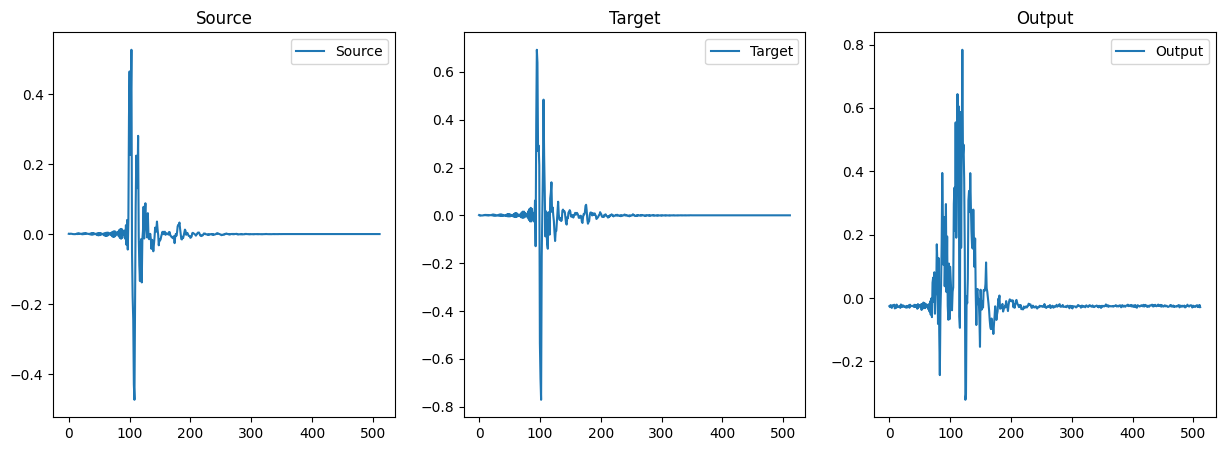

Loss: 0.0131


In [16]:
import matplotlib.pyplot as plt

def test_and_plot(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # No need to track gradients
        # Get one batch from the test_loader
        for hrir0, angle0, hrir90, angle90, hrir45, angle45 in test_loader:
            # move all to device
            hrir0, angle0, hrir90, angle90, hrir45, angle45 = hrir0.to(device), angle0.to(device), hrir90.to(device), angle90.to(device), hrir45.to(device), angle45.to(device)
        
            output = model(hrir0, angle0, hrir90, angle90, hrir45, angle45)
            
            # Plot the first sample in the batch for src, target, and output
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(hrir0[0, 0].cpu().numpy(), label='Source')
            plt.title('Source')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.plot(hrir45[0, 0].cpu().numpy(), label='Target')
            plt.title('Target')
            plt.legend()
            
            plt.subplot(1, 3, 3)
            plt.plot(output[0, 0].cpu().numpy(), label='Output')
            plt.title('Output')
            plt.legend()
            
            plt.show()

            # Print out the loss
            loss = loss_function(output, hrir45)
            print(f'Loss: {loss.item():.4f}')
            
            # Since we only want to plot for the first element, break after the first batch
            break


# Assuming you have a model, test_loader, and device defined
test_and_plot(model, test_loader, device)


In [7]:
output = '''
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=128
Min Train Loss: 0.6338, Avg Train Loss: 0.7705, Median Train Loss: 0.7018
Min Validation Loss: 0.0584, Avg Validation Loss: 0.2511, Median Validation Loss: 0.3002
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=256
Min Train Loss: 0.6339, Avg Train Loss: 0.7610, Median Train Loss: 0.7054
Min Validation Loss: 0.0708, Avg Validation Loss: 0.2011, Median Validation Loss: 0.2160
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=512
Min Train Loss: 0.5203, Avg Train Loss: 0.6520, Median Train Loss: 0.5752
Min Validation Loss: 0.0543, Avg Validation Loss: 0.2358, Median Validation Loss: 0.2624
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=1024
Min Train Loss: 0.4543, Avg Train Loss: 0.6099, Median Train Loss: 0.5182
Min Validation Loss: 0.0905, Avg Validation Loss: 0.4602, Median Validation Loss: 0.5220
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=2048
Min Train Loss: nan, Avg Train Loss: nan, Median Train Loss: nan
Min Validation Loss: nan, Avg Validation Loss: nan, Median Validation Loss: nan
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=4096
Min Train Loss: 0.7329, Avg Train Loss: 0.8400, Median Train Loss: 0.7822
Min Validation Loss: 0.0658, Avg Validation Loss: 0.2734, Median Validation Loss: 0.3296
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=2, dim_feedforward=8192
Min Train Loss: nan, Avg Train Loss: nan, Median Train Loss: nan
Min Validation Loss: nan, Avg Validation Loss: nan, Median Validation Loss: nan
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=128
Min Train Loss: 0.9687, Avg Train Loss: 1.0126, Median Train Loss: 0.9907
Min Validation Loss: 0.0187, Avg Validation Loss: 0.0298, Median Validation Loss: 0.0193
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=256
Min Train Loss: 0.9557, Avg Train Loss: 1.0177, Median Train Loss: 0.9944
Min Validation Loss: 0.0181, Avg Validation Loss: 0.0286, Median Validation Loss: 0.0195
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=512
Min Train Loss: 0.9382, Avg Train Loss: 0.9887, Median Train Loss: 0.9610
Min Validation Loss: 0.0176, Avg Validation Loss: 0.0439, Median Validation Loss: 0.0379
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=1024
Min Train Loss: nan, Avg Train Loss: nan, Median Train Loss: nan
Min Validation Loss: nan, Avg Validation Loss: nan, Median Validation Loss: nan
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=2048
Min Train Loss: 0.9883, Avg Train Loss: 1.0205, Median Train Loss: 0.9964
Min Validation Loss: 0.0181, Avg Validation Loss: 0.0268, Median Validation Loss: 0.0189
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=4096
Min Train Loss: 0.9890, Avg Train Loss: 1.0231, Median Train Loss: 0.9957
Min Validation Loss: 0.0195, Avg Validation Loss: 0.0268, Median Validation Loss: 0.0204
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=8192
Min Train Loss: 0.9880, Avg Train Loss: 1.0238, Median Train Loss: 0.9961
Min Validation Loss: 0.0191, Avg Validation Loss: 0.0256, Median Validation Loss: 0.0204
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=128
Min Train Loss: 0.9815, Avg Train Loss: 1.0207, Median Train Loss: 0.9924
Min Validation Loss: 0.0182, Avg Validation Loss: 0.0273, Median Validation Loss: 0.0207
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=256
Min Train Loss: 0.9443, Avg Train Loss: 1.0037, Median Train Loss: 0.9748
Min Validation Loss: 0.0217, Avg Validation Loss: 0.0305, Median Validation Loss: 0.0243
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=512
Min Train Loss: 0.9638, Avg Train Loss: 1.0118, Median Train Loss: 0.9849
Min Validation Loss: 0.0221, Avg Validation Loss: 0.0359, Median Validation Loss: 0.0347
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=1024
Min Train Loss: 0.9581, Avg Train Loss: 1.0078, Median Train Loss: 0.9773
Min Validation Loss: 0.0165, Avg Validation Loss: 0.0267, Median Validation Loss: 0.0249
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=2048
Min Train Loss: 0.9827, Avg Train Loss: 1.0173, Median Train Loss: 0.9901
Min Validation Loss: 0.0238, Avg Validation Loss: 0.0308, Median Validation Loss: 0.0265
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=4096
Min Train Loss: 0.9787, Avg Train Loss: 1.0168, Median Train Loss: 0.9901
Min Validation Loss: 0.0215, Avg Validation Loss: 0.0273, Median Validation Loss: 0.0229
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=4, dim_feedforward=8192
Min Train Loss: 0.8862, Avg Train Loss: 0.9773, Median Train Loss: 0.9300
Min Validation Loss: 0.0236, Avg Validation Loss: 0.0566, Median Validation Loss: 0.0640
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=5, dim_feedforward=128
Min Train Loss: 0.9561, Avg Train Loss: 1.0090, Median Train Loss: 0.9804
Min Validation Loss: 0.0178, Avg Validation Loss: 0.0296, Median Validation Loss: 0.0252
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=5, dim_feedforward=256
Min Train Loss: 0.9780, Avg Train Loss: 1.0186, Median Train Loss: 0.9902
Min Validation Loss: 0.0178, Avg Validation Loss: 0.0250, Median Validation Loss: 0.0191
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=5, dim_feedforward=512
Min Train Loss: 0.9599, Avg Train Loss: 1.0082, Median Train Loss: 0.9810
Min Validation Loss: 0.0195, Avg Validation Loss: 0.0282, Median Validation Loss: 0.0241
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=5, dim_feedforward=1024
Min Train Loss: 0.9636, Avg Train Loss: 1.0128, Median Train Loss: 0.9853
Min Validation Loss: 0.0186, Avg Validation Loss: 0.0306, Median Validation Loss: 0.0274
Model with parameters: nhead=4, num_encoder_layers=2, num_decoder_layers=5, dim_feedforward=2048
Min Train Loss: 0.9554, Avg Train Loss: 1.0090, Median Train Loss: 0.9810
Min Validation Loss: 0.0188, Avg Validation Loss: 0.0257, Median Validation Loss: 0.0225

'''

In [8]:
import re
pattern = r"Model with parameters: nhead=(\d+), num_encoder_layers=(\d+), num_decoder_layers=(\d+), dim_feedforward=(\d+)\s" \
          r"Min Train Loss: ([\d.]+), Avg Train Loss: ([\d.]+), Median Train Loss: ([\d.]+)\s" \
          r"Min Validation Loss: ([\d.]+), Avg Validation Loss: ([\d.]+), Median Validation Loss: ([\d.]+)"

# Find all matches
matches = re.findall(pattern, output)

# Convert matches to list of dictionaries
results = []
for match in matches:
    result = {
        "nhead": int(match[0]),
        "num_encoder_layers": int(match[1]),
        "num_decoder_layers": int(match[2]),
        "dim_feedforward": int(match[3]),
        "min_train_loss": float(match[4]),
        "avg_train_loss": float(match[5]),
        "median_train_loss": float(match[6]),
        "min_val_loss": float(match[7]),
        "avg_val_loss": float(match[8]),
        "median_val_loss": float(match[9])
    }
    results.append(result)

# Print the extracted information
for result in results:
    print(result)

{'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 128, 'min_train_loss': 0.6338, 'avg_train_loss': 0.7705, 'median_train_loss': 0.7018, 'min_val_loss': 0.0584, 'avg_val_loss': 0.2511, 'median_val_loss': 0.3002}
{'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 256, 'min_train_loss': 0.6339, 'avg_train_loss': 0.761, 'median_train_loss': 0.7054, 'min_val_loss': 0.0708, 'avg_val_loss': 0.2011, 'median_val_loss': 0.216}
{'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 512, 'min_train_loss': 0.5203, 'avg_train_loss': 0.652, 'median_train_loss': 0.5752, 'min_val_loss': 0.0543, 'avg_val_loss': 0.2358, 'median_val_loss': 0.2624}
{'nhead': 4, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'dim_feedforward': 1024, 'min_train_loss': 0.4543, 'avg_train_loss': 0.6099, 'median_train_loss': 0.5182, 'min_val_loss': 0.0905, 'avg_val_loss': 0.4602, 'median_val_loss': 0.522}
{'nhead': 4, 'num_encoder_layer

In [12]:
hyper_dict

{(4,
  2,
  2,
  128): ([1.1940816442171733,
   1.0939471754762862,
   1.0284080935849085,
   0.9849201507038541,
   0.9284305274486542,
   0.8555513785945045,
   0.8115296992990706,
   0.7847364644209543,
   0.7488832771778107,
   0.7087344891495175,
   0.6742972864045037,
   0.661608960893419,
   0.6093938681814406,
   0.5888364182578193,
   0.5808214777045779,
   0.5528363254335191,
   0.5423910601271523,
   0.5216421882311503,
   0.5021763245264689,
   0.4928634729650285,
   0.47983258962631226,
   0.47216226988368565,
   0.47290630141894024,
   0.4421597603294585,
   0.43310896224445766,
   0.4214458051655028,
   0.40905476609865826,
   0.4081724137067795,
   0.4017705106072956,
   0.4068363805611928,
   0.3835386269622379,
   0.3941490484608544,
   0.37253745396931964,
   0.37216146455870736,
   0.37871281968222725,
   0.3550049430794186,
   0.3573419435156716,
   0.35335756838321686,
   0.34944025178750354,
   0.3502366029553943,
   0.3384972694847319,
   0.32914425598250496,
  

In [10]:
import xgboost as xgb
import numpy as np

class HRIRPredictor:
    def __init__(self, n_estimators=100, max_depth=3, learning_rate=0.1):
        """
        Initialize the HRIR predictor with XGBoost parameters.
        
        Parameters:
        - n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.
        - max_depth: Maximum tree depth for base learners.
        - learning_rate: Boosting learning rate (xgb's "eta")
        """
        self.model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    
    def prepare_data(self, hrir_input, angles):
        """
        Prepares the data for training or prediction. This function assumes the HRIR data
        is passed as a numpy array where each row is an HRIR sample, and angles are provided
        as a numpy array of corresponding angles.
        
        Parameters:
        - hrir_input: A 2D numpy array of shape (n_samples, hrir_length).
        - angles: A 1D numpy array of angles corresponding to each HRIR sample.
        
        Returns:
        - A 2D numpy array where each sample is concatenated with its corresponding angle.
        """
        # Assuming angles is a 1D numpy array and needs to be reshaped to concatenate with hrir_input
        print(hrir_input.shape, angles.shape)
        angles_expanded = angles[:, np.newaxis]  # Reshape angles to be a 2D array of shape (n_samples, 1)
        data = np.concatenate([hrir_input, angles_expanded], axis=1)  # Concatenate along the columns
        return data
    
    def fit(self, X_train, y_train, angles_train):
        """
        Train the XGBoost model on the provided HRIR data and angles.
        
        Parameters:
        - X_train: A 2D numpy array of input HRIR samples.
        - y_train: A 2D numpy array of target HRIR samples to predict.
        - angles_train: A 1D numpy array of angles corresponding to each HRIR sample in X_train.
        """
        # Prepare the training data
        train_data = self.prepare_data(X_train, angles_train)
        self.model.fit(train_data, y_train)
    
    def predict(self, X_test, angles_test):
        """
        Predict the HRIR given new HRIR data and angles using the trained model.
        
        Parameters:
        - X_test: A 2D numpy array of input HRIR samples for prediction.
        - angles_test: A 1D numpy array of angles corresponding to each HRIR sample in X_test.
        
        Returns:
        - A 2D numpy array of predicted HRIR samples.
        """
        # Prepare the test data
        test_data = self.prepare_data(X_test, angles_test)
        return self.model.predict(test_data)





In [11]:
model = HRIRPredictor(n_estimators=100, max_depth=3, learning_rate=0.1)

In [1]:
import sys
sys.path.append('/workspace/fourth_year_project/HRTF Models/')

from BasicDataset import BasicDataset
# from BasicTransformer import BasicTransformer

sofa_file = '/workspace/fourth_year_project/HRTF Models/sofa_hrtfs/RIEC_hrir_subject_001.sofa'
# Basic Dataset only loads the HRIRs at 0 degrees and 90 degrees for baseline and 45 degree for testing
hrir_dataset = BasicDataset()
for i in range(1,100):
    hrir_dataset.load(sofa_file.replace('001', str(i).zfill(3)))

hrir0, angle0, hrir90, angle90, hrir45, angle45 = hrir_dataset.get_all()



In [36]:
# Get indexes of 0, 45, 90
import numpy as np

hrir_w_angle0 = np.concatenate((hrir0, np.array(angle0).reshape(99, 1, 1) * np.ones((99, 1, 512))), axis=1)
hrir_w_angle90 = np.concatenate((hrir90, np.array(angle90).reshape(99, 1, 1) * np.ones((99, 1, 512))), axis=1)

# Use 0 and 90 as train, 45 is what we want to predict
# hrirs = np.concatenate([hrir0, hrir90], axis=1)
# angles = np.concatenate([angle0, angle90], axis=1)

hrir_w_angle = np.concatenate([hrir_w_angle0, hrir_w_angle90], axis=1)

In [37]:
hrir_w_angle.shape

(99, 6, 512)

In [38]:
np_angle45 = np.array(angle45).reshape(99, 1, 1) * np.ones((99, 1, 512))

In [39]:
np_angle45.shape

(99, 1, 512)

In [40]:
hrir_w_angle = np.concatenate([hrir_w_angle, np_angle45], axis=1)
hrir_w_angle.shape

(99, 7, 512)

In [43]:
target = np.array(hrir45)[:,0,:].reshape(99, 1, 512)
target.shape

(99, 1, 512)

In [44]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

inputs = hrir_w_angle.reshape(99, -1)
target = target.reshape(99, -1)
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=42)

In [52]:
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=10, alpha=10, n_estimators=100)

# XGBoost expects 2D input for y if predicting multiple outputs, which we have prepared
model.fit(X_train, y_train)

# Making predictions
predictions = model.predict(X_test)

# Evaluating the model - this example uses RMSE, consider adjusting for multi-output
rmse = np.sqrt(mean_squared_error(y_test, predictions, multioutput='raw_values'))
print(f"RMSE: {rmse}")


RMSE: [0.00190521 0.00224655 0.00167643 0.00198121 0.00194867 0.00279147
 0.00312522 0.00317197 0.0027345  0.00222221 0.00180301 0.00194808
 0.00208339 0.00245969 0.00258889 0.00271421 0.00237771 0.0024036
 0.00223826 0.00198274 0.00204243 0.00182977 0.00194016 0.00197549
 0.00198102 0.00179046 0.00176416 0.00231825 0.00234067 0.00262038
 0.00252182 0.00246584 0.00230699 0.00201891 0.00225596 0.00189604
 0.00244115 0.00238684 0.00289508 0.00294856 0.00336184 0.00335368
 0.00355083 0.0033579  0.00322736 0.00272617 0.00272911 0.00308264
 0.00297486 0.00381001 0.0038145  0.0045657  0.00501122 0.0054861
 0.00590034 0.00596047 0.00574592 0.00480472 0.00400278 0.00339641
 0.0036172  0.00460183 0.00615199 0.00736145 0.00895565 0.00963975
 0.01025196 0.01020529 0.00939792 0.00843247 0.00693984 0.00593959
 0.00611336 0.00948255 0.01546496 0.02649212 0.23458084 0.15419103
 0.09074854 0.1282612  0.20275101 0.12219176 0.05590379 0.14153917
 0.01963474 0.08879793 0.03931944 0.25392267 0.13555738 0.

In [62]:
ground_truth = y_test[10].reshape(1, 512)
prediction = predictions[10].reshape(1, 512)
ground_truth.shape, prediction.shape

((1, 512), (1, 512))

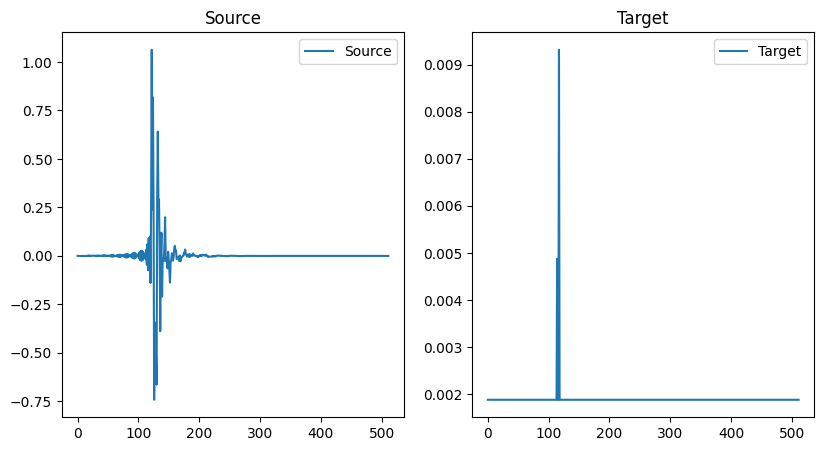

In [63]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(ground_truth[0], label='Source')
plt.title('Source')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(prediction[0], label='Target')
plt.title('Target')
plt.legend()


plt.show()
            